- In order to run this causalnex package, the python should be 3.8.

- You should use python 3.6, 3.7, or 3.8 for causalnex:

    conda create -n env_name python=3.8 anaconda

- For requirements please check "requirements.txt"

- For environments please check "environment.yml"

- if you are MacOS, you may need to install
    brew install gfortran

In [13]:
import warnings
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import pickle

warnings.filterwarnings("ignore")  # silence warnings

sm = StructureModel()

%config InlineBackend.figure_format = 'jpeg'

In [2]:
domain_knowledge = [('health','absenses'),
    ('halth', 'G1')]
sm.add_edges_from(domain_knowledge)
sm.edges

print(sm)

StructureModel with 4 nodes and 2 edges


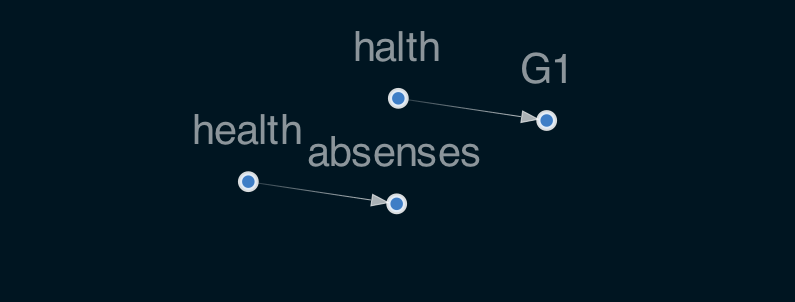

In [3]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))


In [4]:
data = pd.read_csv('student-por.csv', delimiter=';')
drop_col = ['school','sex','age','Mjob', 'Fjob','reason','guardian']
data = data.drop(columns=drop_col)
data.head()

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,U,GT3,A,4,4,2,2,0,yes,no,...,4,3,4,1,1,3,4,0,11,11
1,U,GT3,T,1,1,1,2,0,no,yes,...,5,3,3,1,1,3,2,9,11,11
2,U,LE3,T,1,1,1,2,0,yes,no,...,4,3,2,2,3,3,6,12,13,12
3,U,GT3,T,4,2,1,3,0,no,yes,...,3,2,2,1,1,5,0,14,14,14
4,U,GT3,T,3,3,1,2,0,no,yes,...,4,3,2,1,2,5,0,11,13,13


In [5]:
struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [6]:
le = LabelEncoder() # Encoding nominal variables into discrete numeric variables

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,0,4,4,2,2,0,1,0,...,4,3,4,1,1,3,4,0,11,11
1,1,0,1,1,1,1,2,0,0,1,...,5,3,3,1,1,3,2,9,11,11
2,1,1,1,1,1,1,2,0,1,0,...,4,3,2,2,3,3,6,12,13,12
3,1,0,1,4,2,1,3,0,0,1,...,3,2,2,1,1,5,0,14,14,14
4,1,0,1,3,3,1,2,0,0,1,...,4,3,2,1,2,5,0,11,13,13


In [7]:
sm2 = from_pandas(struct_data) # Causal structure learning

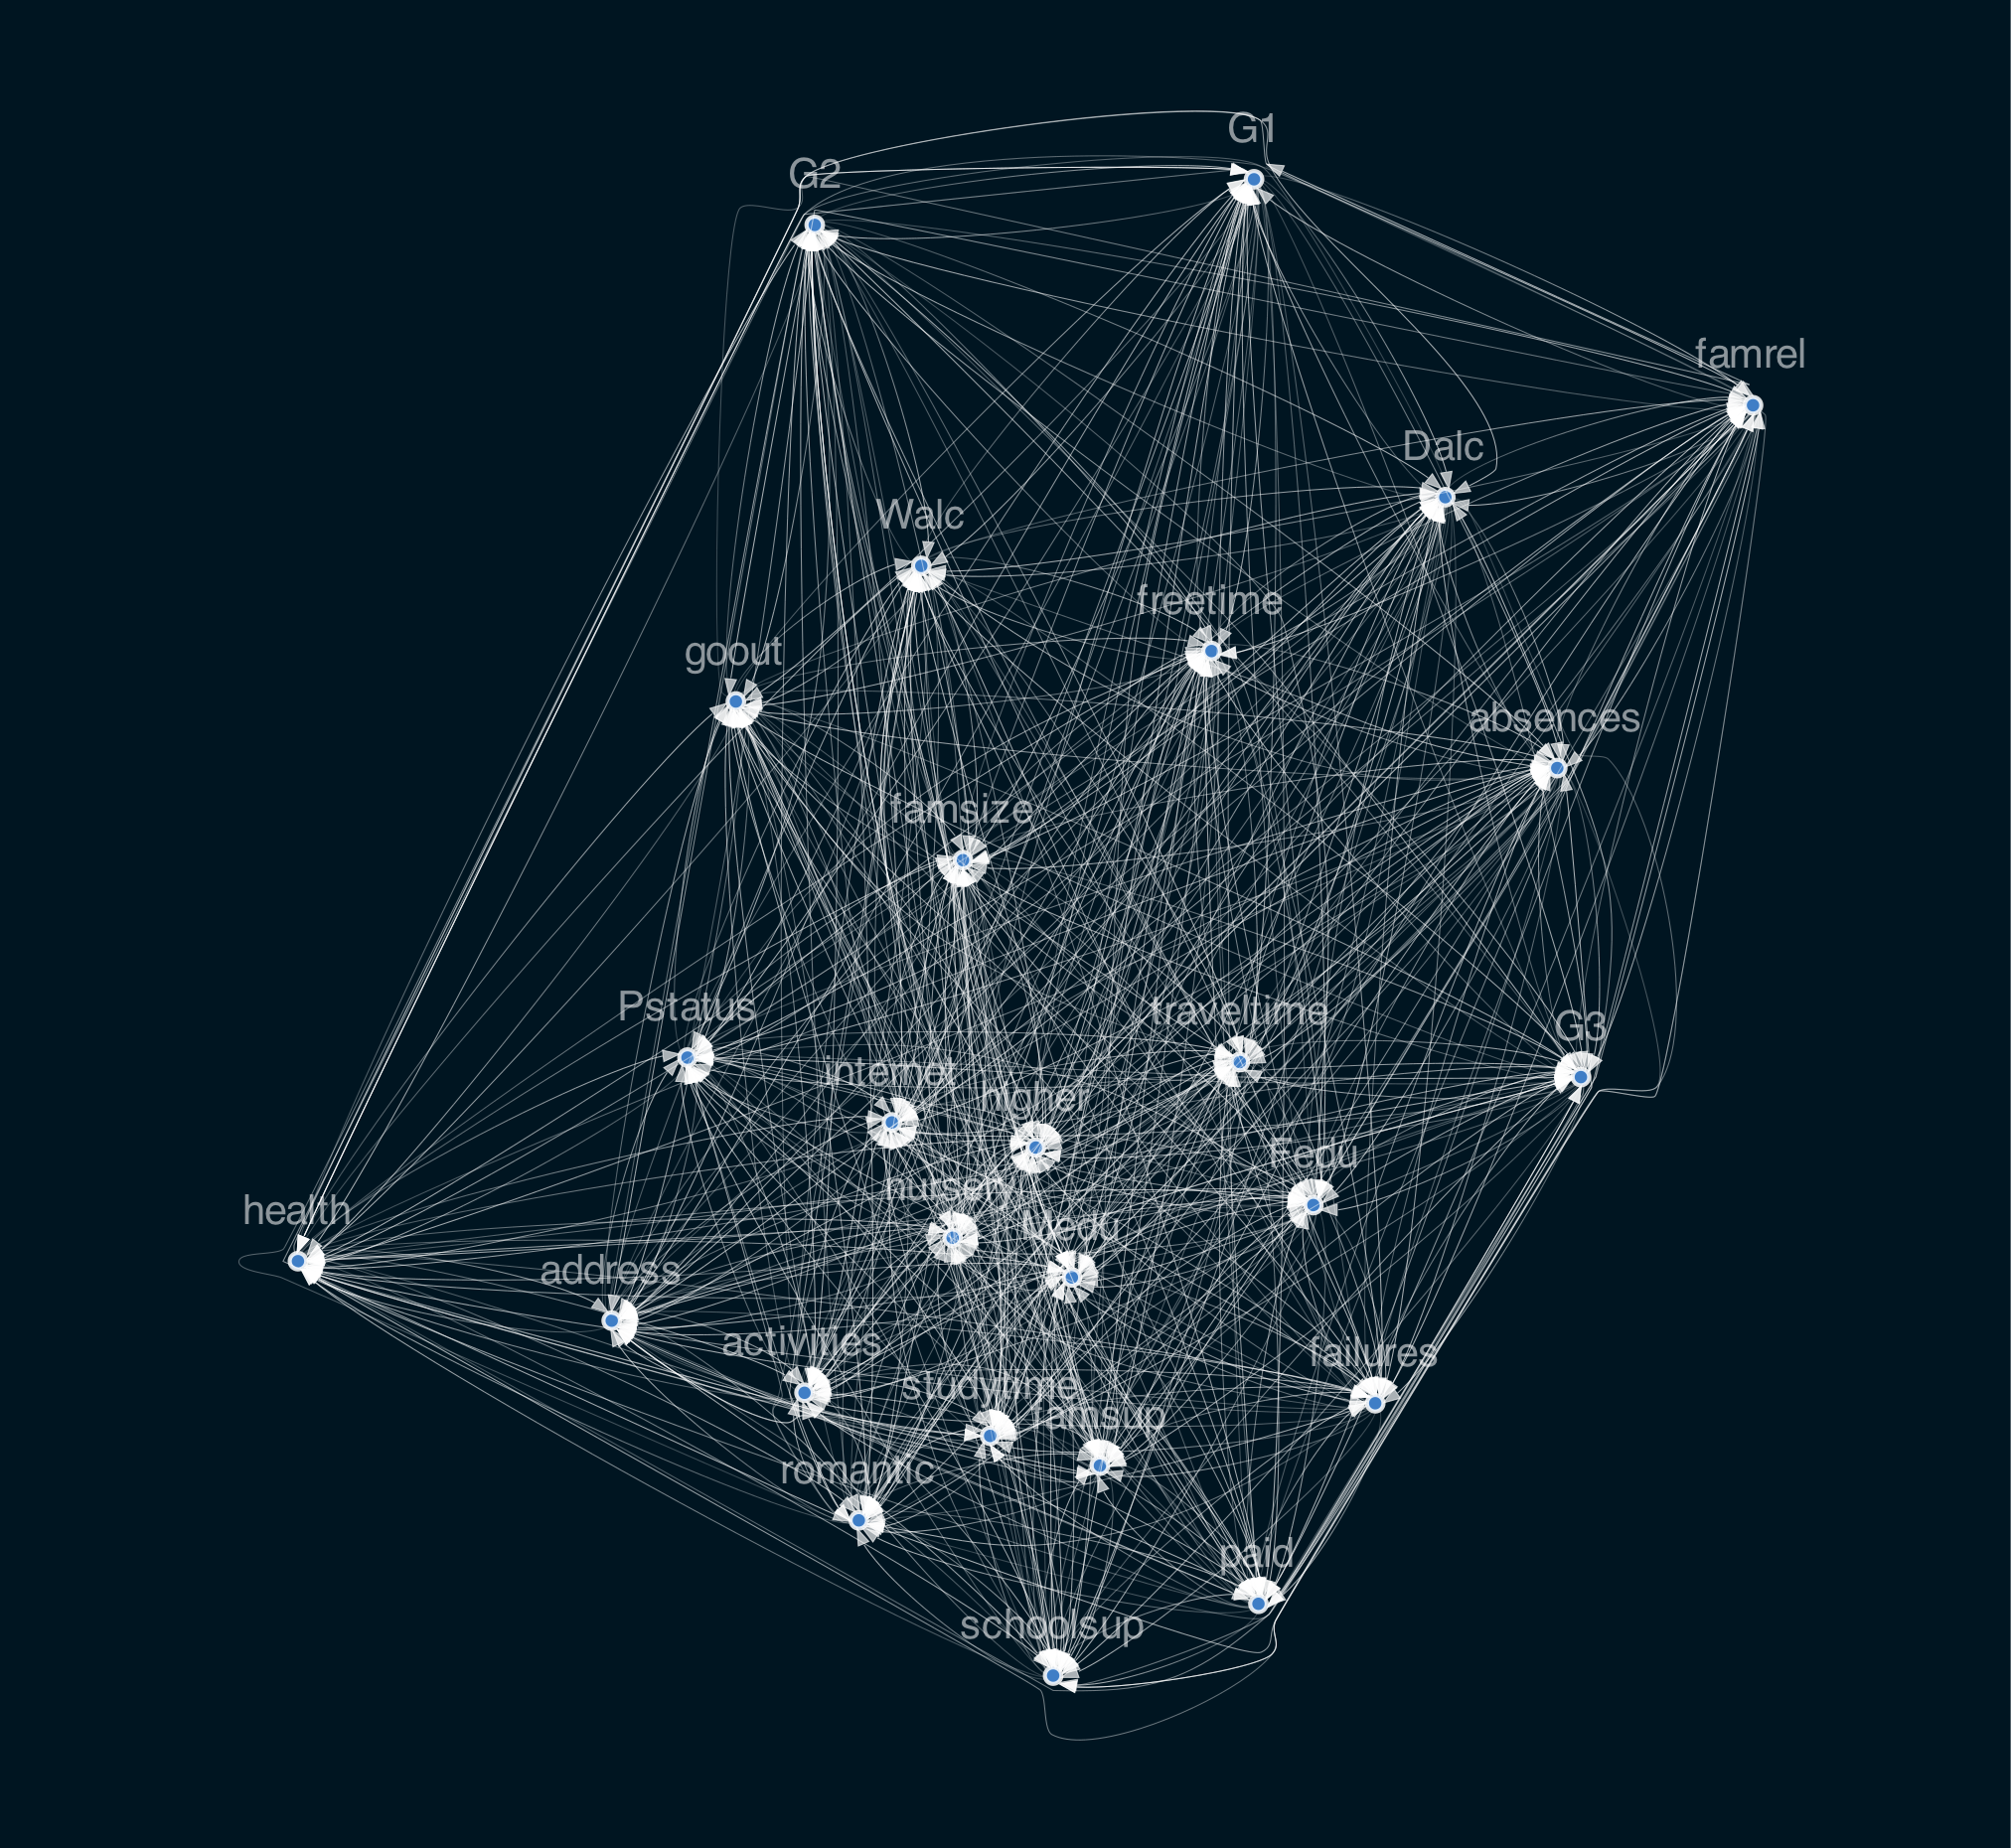

In [10]:
viz = plot_structure(
    sm2,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

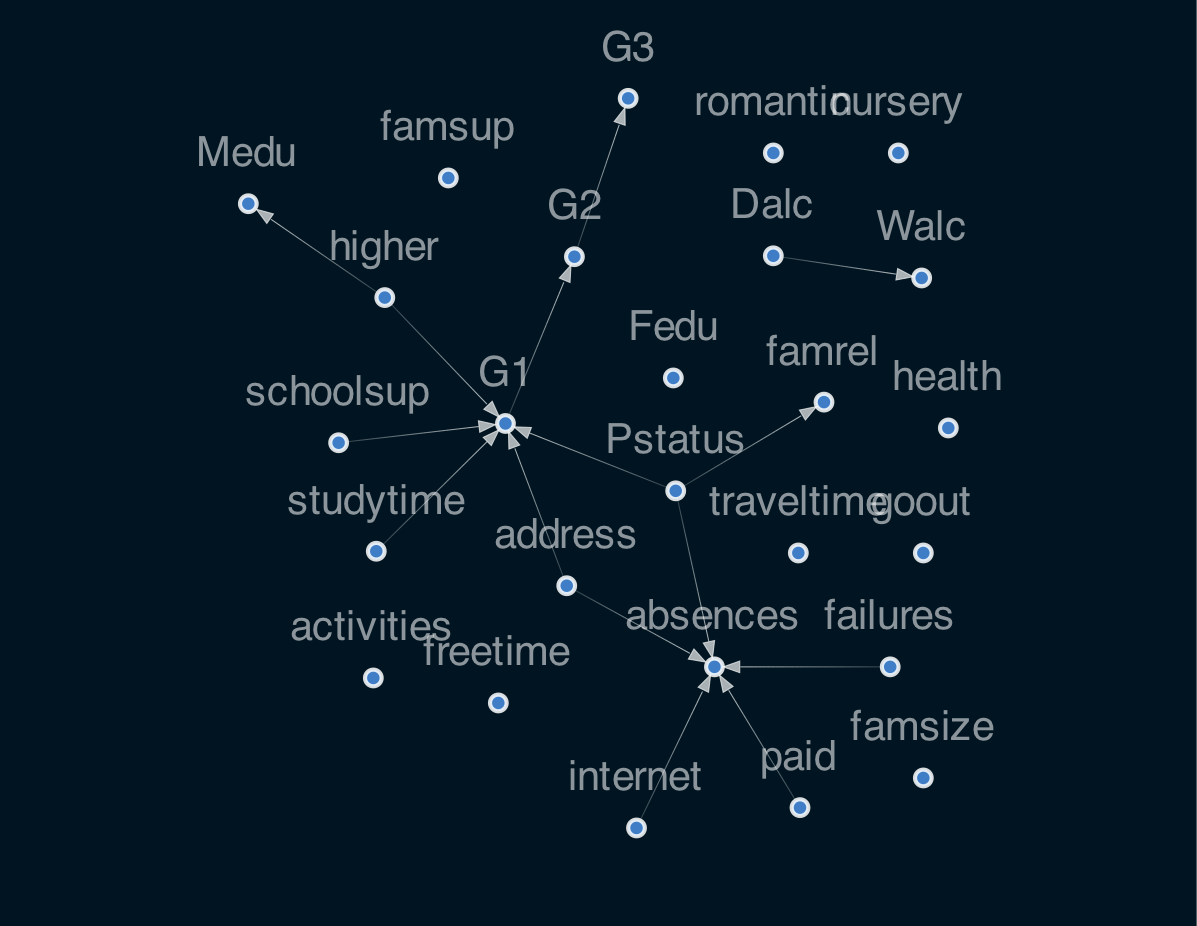

In [22]:
sm2.remove_edges_below_threshold(0.8) # if not threshold? 
viz = plot_structure(
    sm2,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))
#nx.drawing.nx_pydot.write_dot(sm2, 'graph2.dot')
#x = nx.drawing.nx_pydot.read_dot('graph2.dot')

In [23]:
sm3 = from_pandas(struct_data, tabu_edges=[("higher", "Medu")], w_threshold=0.8)

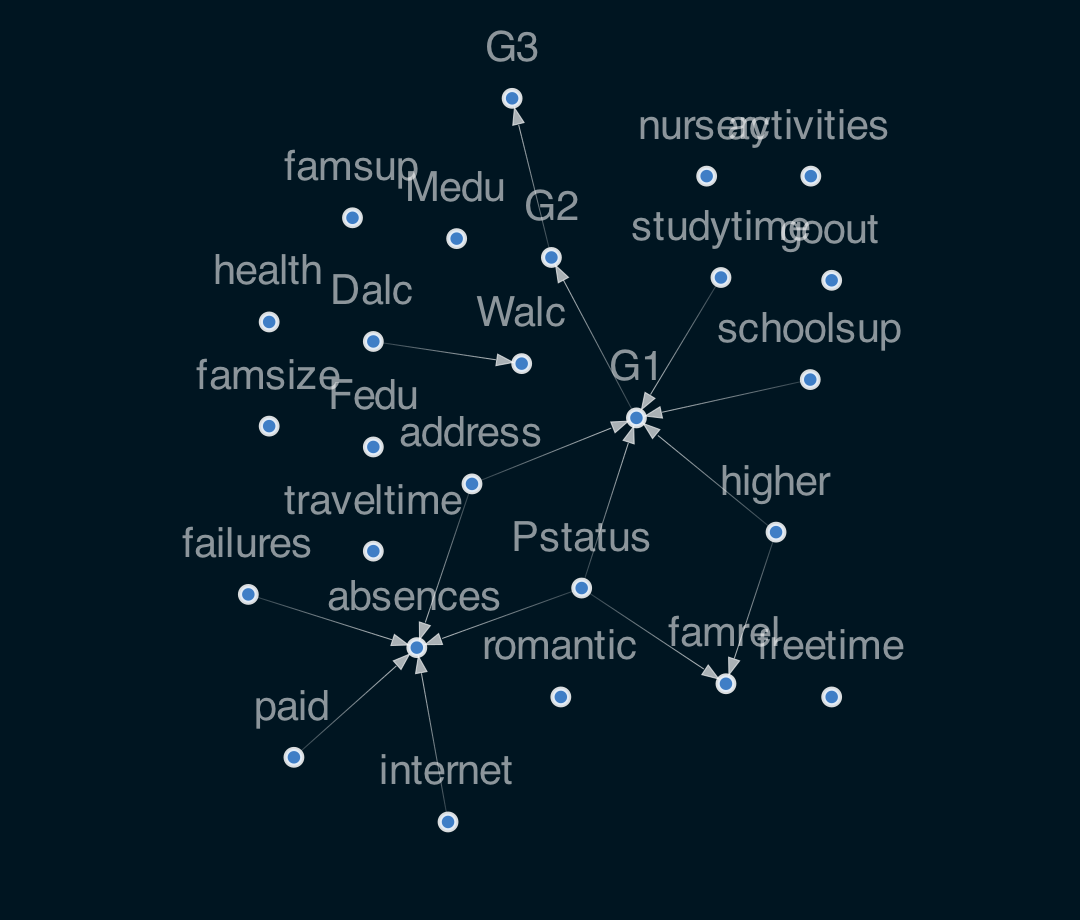

In [24]:
viz = plot_structure(
    sm3,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [25]:
sm4 = sm3 

sm4.add_edge("failures", "G1")
sm4.remove_edge("Pstatus", "G1")
sm4.remove_edge("address", "G1")

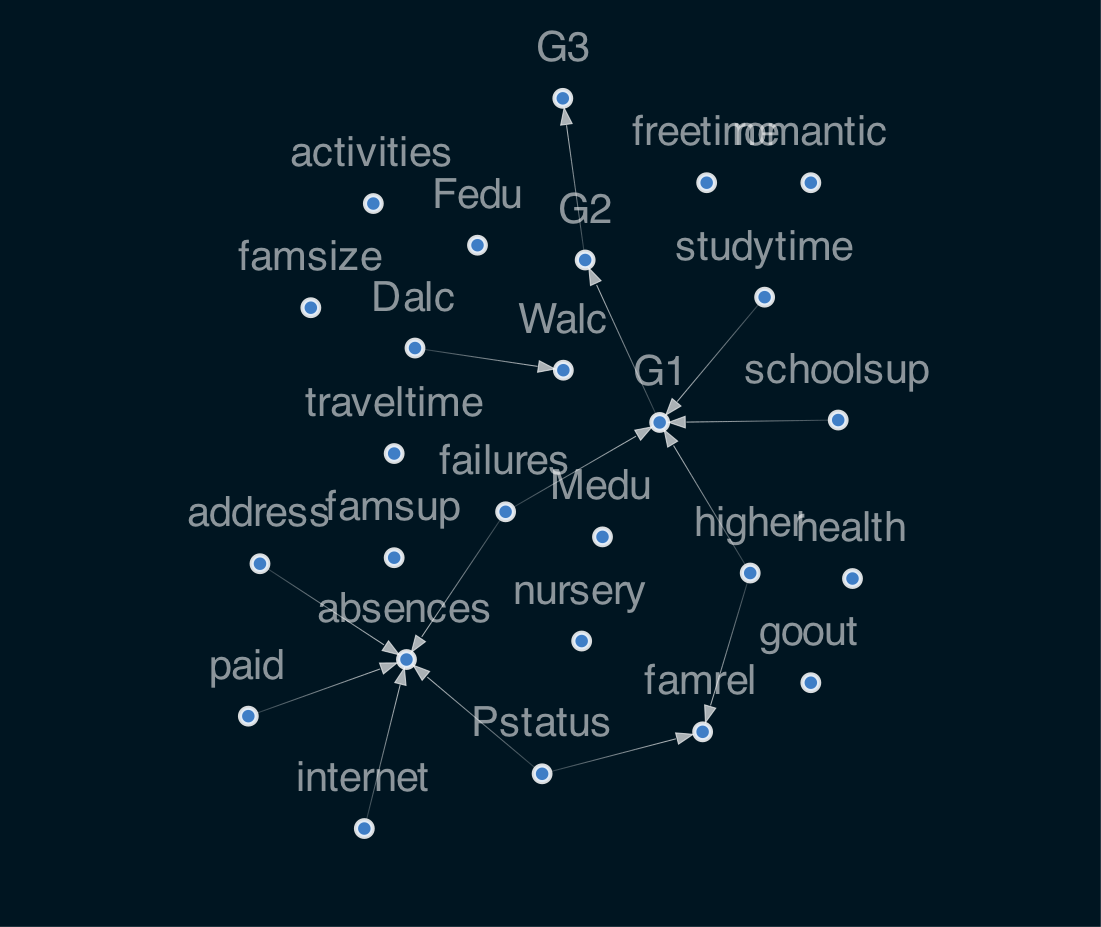

In [26]:
viz = plot_structure(
    sm4,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

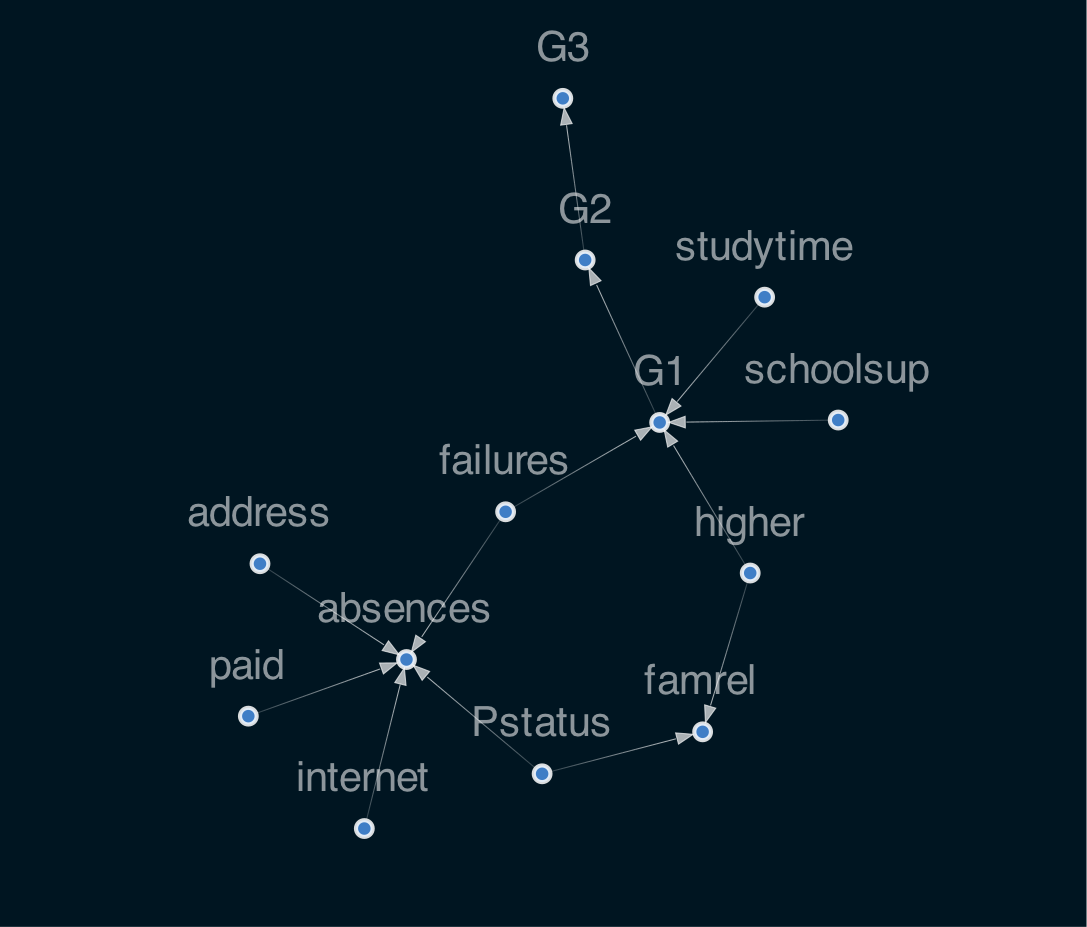

In [32]:
sm5 = sm4.get_largest_subgraph()
viz = plot_structure(
    sm5,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [33]:
nx.drawing.nx_pydot.write_dot(sm5, 'graph5.dot')
#x = nx.drawing.nx_pydot.read_dot('graph2.dot')

In [34]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)

In [35]:
discretised_data = data.copy()

data_vals = {col: data[col].unique() for col in data.columns}

failures_map = {v: 'no-failure' if v == [0]
                else 'have-failure' for v in data_vals['failures']}
studytime_map = {v: 'short-studytime' if v in [1,2]
                 else 'long-studytime' for v in data_vals['studytime']}